In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/glaucoma-classification-datasets/LAG/LAG/Training/glaucoma/0664.jpg
/kaggle/input/glaucoma-classification-datasets/LAG/LAG/Training/glaucoma/3863.jpg
/kaggle/input/glaucoma-classification-datasets/LAG/LAG/Training/glaucoma/2008.jpg
/kaggle/input/glaucoma-classification-datasets/LAG/LAG/Training/glaucoma/0106.jpg
/kaggle/input/glaucoma-classification-datasets/LAG/LAG/Training/glaucoma/3417.jpg
/kaggle/input/glaucoma-classification-datasets/LAG/LAG/Training/glaucoma/5705.jpg
/kaggle/input/glaucoma-classification-datasets/LAG/LAG/Training/glaucoma/5307.jpg
/kaggle/input/glaucoma-classification-datasets/LAG/LAG/Training/glaucoma/1700.jpg
/kaggle/input/glaucoma-classification-datasets/LAG/LAG/Training/glaucoma/3501.jpg
/kaggle/input/glaucoma-classification-datasets/LAG/LAG/Training/glaucoma/5333.jpg
/kaggle/input/glaucoma-classification-datasets/LAG/LAG/Training/glaucoma/2628.jpg
/kaggle/input/glaucoma-classification-datasets/LAG/LAG/Training/glaucoma/4009.jpg
/kaggle/input/gl

In [3]:
!ls /kaggle/input/glaucoma-classification-datasets/LAG/LAG/Testing
!ls /kaggle/input/glaucoma-classification-datasets/LAG/LAG/Training


!ls /kaggle/input/glaucoma-classification-datasets/ACRIMA/ACRIMA/NOT PARTITIONED
!ls /kaggle/input/glaucoma-classification-datasets/ACRIMA/ACRIMA/PARTITIONED

!ls /kaggle/input/glaucoma-classification-datasets/DRISHTI-GS/DRISHTI-GS/Testing
!ls /kaggle/input/glaucoma-classification-datasets/DRISHTI-GS/DRISHTI-GS/Training


!ls /kaggle/input/glaucoma-classification-datasets/G1020/G1020/Testing
!ls /kaggle/input/glaucoma-classification-datasets/G1020/G1020/Training


!ls /kaggle/input/glaucoma-classification-datasets/ORIGA/ORIGA/Testing
!ls /kaggle/input/glaucoma-classification-datasets/ORIGA/ORIGA/Training


!ls /kaggle/input/glaucoma-classification-datasets/RIM-ONE/RIM-ONE/NOT PARTITIONED
!ls /kaggle/input/glaucoma-classification-datasets/RIM-ONE/RIM-ONE/PARTITIONED/Testing
!ls /kaggle/input/glaucoma-classification-datasets/RIM-ONE/RIM-ONE/PARTITIONED/Training








glaucoma  normal
glaucoma  normal
ls: cannot access '/kaggle/input/glaucoma-classification-datasets/ACRIMA/ACRIMA/NOT': No such file or directory
ls: cannot access 'PARTITIONED': No such file or directory
Testing  Training
glaucoma  normal
glaucoma  normal
glaucoma  normal
glaucoma  normal
glaucoma  normal
glaucoma  normal
ls: cannot access '/kaggle/input/glaucoma-classification-datasets/RIM-ONE/RIM-ONE/NOT': No such file or directory
ls: cannot access 'PARTITIONED': No such file or directory
glaucoma  normal
glaucoma  normal


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, models, transforms
import os
import numpy as np

print("PyTorch Version:", torch.__version__)

# --- 1. Define the Preprocessing Pipeline (Transforms) ---
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

data_transforms = {
    'Training': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std)
    ]),
    'Validation': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std)
    ])
}
print("Preprocessing pipelines defined successfully.")

# --- 2. Load the Datasets from the correct folders ---
base_dir = '/kaggle/input/glaucoma-classification-datasets/LAG/LAG/'

# Load the *entire* original training set with 'Validation' transforms
full_train_dataset = datasets.ImageFolder(
    os.path.join(base_dir, 'Training'),
    transform=data_transforms['Validation']
)

# Load the test set
test_dataset = datasets.ImageFolder(
    os.path.join(base_dir, 'Testing'),
    transform=data_transforms['Validation']
)

print(f"Loaded {len(full_train_dataset)} images from Training.")
print(f"Loaded {len(test_dataset)} images from Testing.")

# --- 3. Split the Training Set into Train and Validation ---
val_split = 0.2
total_train_size = len(full_train_dataset)
val_size = int(total_train_size * val_split)
train_size = total_train_size - val_size

train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Define our custom subset class to apply the correct transform
class CustomSubset(Subset):
    def __init__(self, dataset, indices, transform=None):
        super().__init__(dataset, indices)
        self.transform = transform

    def __getitem__(self, idx):
        # Get the original image and label
        # self.dataset points to full_train_dataset
        # self.indices is the list of indices for this subset
        x, y = self.dataset.samples[self.indices[idx]] # Get path and label
        
        # Load the image
        loader = self.dataset.loader
        x = loader(x) # x is now a PIL Image
        
        # Apply our new (augmented) transform
        if self.transform:
            x = self.transform(x)
        return x, y

# Re-create the train_dataset with the 'Training' (augmented) transform
train_dataset = CustomSubset(
    full_train_dataset, # <-- [THE FIX IS HERE] Pass the ImageFolder directly
    train_dataset.indices,      # Use the same split indices
    transform=data_transforms['Training'] # Apply the augmentation transform
)

# Re-create the val_dataset (it doesn't *need* a new transform, but
# this ensures it uses the same optimized __getitem__ method)
val_dataset = CustomSubset(
    full_train_dataset,
    val_dataset.indices,
    transform=data_transforms['Validation'] # Apply the validation transform
)

print(f"Successfully split data:")
print(f"  New Training set size: {len(train_dataset)}")
print(f"  New Validation set size: {len(val_dataset)}")
print(f"  Testing set size: {len(test_dataset)}")

# --- 4. Create the DataLoaders ---
batch_size = 32

dataloaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2),
    'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2),
    'test': DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
}
print("\nDataLoaders created successfully.")

class_names = full_train_dataset.classes
print("Class names found:", class_names)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Current device:", device)

PyTorch Version: 2.6.0+cu124
Preprocessing pipelines defined successfully.
Loaded 3883 images from Training.
Loaded 971 images from Testing.
Successfully split data:
  New Training set size: 3107
  New Validation set size: 776
  Testing set size: 971

DataLoaders created successfully.
Class names found: ['glaucoma', 'normal']
Current device: cuda:0


In [5]:
import time
import copy

# --- 1. Set up the Model (MobileNetV2) ---

# Load a pre-trained MobileNetV2 model
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)

# "Freezing" the pre-trained layers
# We tell PyTorch not to update the weights of these layers
for param in model.parameters():
    param.requires_grad = False

# --- 2. Replace the Final Classifier Layer ---

# MobileNetV2's final layer is called 'classifier'
# It has 1000 output features (for 1000 ImageNet classes)
num_features = model.classifier[1].in_features

# We replace it with a new layer for our 2 classes ('glaucoma', 'normal')
model.classifier[1] = nn.Linear(num_features, len(class_names))

print("Model architecture loaded and final layer replaced:")
print(model.classifier) # Show the new final layer

# --- 3. Define Loss Function and Optimizer ---

# Our "loss function" (how we measure error)
# CrossEntropyLoss is perfect for multi-class classification
criterion = nn.CrossEntropyLoss()

# Our "optimizer" (how the model learns)
# We only want to train the weights of the *new* layer
# 'model.classifier.parameters()' tells the optimizer to ONLY update the classifier
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

# --- 4. Move the Model to the GPU ---

# This sends the model's parameters to the GPU for fast computation
# (Make sure your notebook's accelerator is set to GPU!)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(f"\nModel is now on device: {device}")
if device.type == 'cpu':
    print("WARNING: GPU is not enabled! Training will be very slow.")
    print("Go to Settings -> Accelerator -> Set to GPU.")

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 118MB/s] 


Model architecture loaded and final layer replaced:
Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=2, bias=True)
)

Model is now on device: cuda:0


In [6]:
import time
import copy
from tqdm import tqdm # A library to show a nice progress bar

# This is the path where we will save our best model
# It saves to /kaggle/working/, which is the output directory
BEST_MODEL_PATH = "glaucoma_mobilenet_best.pth"

def train_model(model, criterion, optimizer, num_epochs=20):
    """
    The main training engine.
    
    Args:
        model: The MobileNetV2 model
        criterion: The loss function (CrossEntropyLoss)
        optimizer: The optimizer (Adam)
        num_epochs: How many times to loop over the data
    
    Returns:
        model: The best performing model
        history: A dictionary of training and validation accuracy/loss
    """
    
    start_time = time.time()

    # Initialize variables to track the best model
    best_model_weights = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    # Dictionaries to store our results
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode (enables dropout, etc.)
            else:
                model.eval()   # Set model to evaluate mode (disables dropout, etc.)

            running_loss = 0.0
            running_corrects = 0

            # Get the correct dataloader for the phase
            # We use tqdm() to wrap the dataloader for a progress bar
            dataloader_for_phase = dataloaders[phase]
            
            # Iterate over the data
            for inputs, labels in tqdm(dataloader_for_phase, desc=phase):
                # Move inputs and labels to the GPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # --- Forward pass ---
                # Zero the gradients
                optimizer.zero_grad()
                
                # Only track history (for gradients) in the training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) # Get the "best guess"
                    loss = criterion(outputs, labels)

                    # --- Backward pass + optimize (only in train phase) ---
                    if phase == 'train':
                        loss.backward() # Calculate gradients
                        optimizer.step() # Update weights

                # --- Statistics ---
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # Calculate loss and accuracy for the *entire* epoch
            epoch_loss = running_loss / len(dataloader_for_phase.dataset)
            epoch_acc = running_corrects.double() / len(dataloader_for_phase.dataset)

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item()) # .item() gets the Python number

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # --- CHECKPOINTING ---
            # If this is the validation phase AND it's the best model so far...
            if phase == 'val' and epoch_acc > best_acc:
                print(f"✅ New best model found! Acc: {epoch_acc:.4f}")
                best_acc = epoch_acc
                # Save the model's weights
                best_model_weights = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), BEST_MODEL_PATH)

    # --- End of Training ---
    time_elapsed = time.time() - start_time
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'🏆 Best Validation Acc: {best_acc:4f}')

    # Load the best model weights back into the model
    model.load_state_dict(best_model_weights)
    return model, history

# --- 🚀 RUN THE TRAINING! ---
print("Starting training...")

# We will run for 20 epochs. You can change this number.
# We're using the 'model', 'criterion', and 'optimizer' we defined in the last cell.
model, history = train_model(model, criterion, optimizer, num_epochs=20)

print("\n--- Training Finished ---")

Starting training...

Epoch 1/20
----------


train: 100%|██████████| 98/98 [00:15<00:00,  6.16it/s]


train Loss: 0.4581 Acc: 0.7786


val: 100%|██████████| 25/25 [00:03<00:00,  6.55it/s]


val Loss: 0.3735 Acc: 0.8389
✅ New best model found! Acc: 0.8389

Epoch 2/20
----------


train: 100%|██████████| 98/98 [00:11<00:00,  8.84it/s]


train Loss: 0.3474 Acc: 0.8474


val: 100%|██████████| 25/25 [00:02<00:00,  8.77it/s]


val Loss: 0.3420 Acc: 0.8582
✅ New best model found! Acc: 0.8582

Epoch 3/20
----------


train: 100%|██████████| 98/98 [00:10<00:00,  9.09it/s]


train Loss: 0.3259 Acc: 0.8616


val: 100%|██████████| 25/25 [00:02<00:00,  9.28it/s]


val Loss: 0.3123 Acc: 0.8737
✅ New best model found! Acc: 0.8737

Epoch 4/20
----------


train: 100%|██████████| 98/98 [00:10<00:00,  9.10it/s]


train Loss: 0.3006 Acc: 0.8767


val: 100%|██████████| 25/25 [00:02<00:00,  8.83it/s]


val Loss: 0.3115 Acc: 0.8711

Epoch 5/20
----------


train: 100%|██████████| 98/98 [00:10<00:00,  9.02it/s]


train Loss: 0.2879 Acc: 0.8806


val: 100%|██████████| 25/25 [00:02<00:00,  8.90it/s]


val Loss: 0.2870 Acc: 0.8827
✅ New best model found! Acc: 0.8827

Epoch 6/20
----------


train: 100%|██████████| 98/98 [00:11<00:00,  8.88it/s]


train Loss: 0.2783 Acc: 0.8922


val: 100%|██████████| 25/25 [00:02<00:00,  8.97it/s]


val Loss: 0.2811 Acc: 0.8711

Epoch 7/20
----------


train: 100%|██████████| 98/98 [00:11<00:00,  8.74it/s]


train Loss: 0.2753 Acc: 0.8848


val: 100%|██████████| 25/25 [00:02<00:00,  8.86it/s]


val Loss: 0.2813 Acc: 0.8789

Epoch 8/20
----------


train: 100%|██████████| 98/98 [00:10<00:00,  9.00it/s]


train Loss: 0.2609 Acc: 0.8899


val: 100%|██████████| 25/25 [00:02<00:00,  8.96it/s]


val Loss: 0.2706 Acc: 0.8930
✅ New best model found! Acc: 0.8930

Epoch 9/20
----------


train: 100%|██████████| 98/98 [00:11<00:00,  8.42it/s]


train Loss: 0.2635 Acc: 0.8922


val: 100%|██████████| 25/25 [00:02<00:00,  9.13it/s]


val Loss: 0.2732 Acc: 0.8892

Epoch 10/20
----------


train: 100%|██████████| 98/98 [00:10<00:00,  9.51it/s]


train Loss: 0.2675 Acc: 0.8925


val: 100%|██████████| 25/25 [00:02<00:00,  8.75it/s]


val Loss: 0.2681 Acc: 0.8879

Epoch 11/20
----------


train: 100%|██████████| 98/98 [00:10<00:00,  9.16it/s]


train Loss: 0.2515 Acc: 0.9028


val: 100%|██████████| 25/25 [00:02<00:00,  9.28it/s]


val Loss: 0.2664 Acc: 0.8918

Epoch 12/20
----------


train: 100%|██████████| 98/98 [00:10<00:00,  9.46it/s]


train Loss: 0.2618 Acc: 0.8931


val: 100%|██████████| 25/25 [00:02<00:00,  9.07it/s]


val Loss: 0.2594 Acc: 0.8956
✅ New best model found! Acc: 0.8956

Epoch 13/20
----------


train: 100%|██████████| 98/98 [00:10<00:00,  9.35it/s]


train Loss: 0.2402 Acc: 0.9038


val: 100%|██████████| 25/25 [00:02<00:00,  8.65it/s]


val Loss: 0.2623 Acc: 0.8905

Epoch 14/20
----------


train: 100%|██████████| 98/98 [00:10<00:00,  9.46it/s]


train Loss: 0.2428 Acc: 0.9009


val: 100%|██████████| 25/25 [00:02<00:00,  9.20it/s]


val Loss: 0.2588 Acc: 0.8879

Epoch 15/20
----------


train: 100%|██████████| 98/98 [00:10<00:00,  9.31it/s]


train Loss: 0.2326 Acc: 0.9012


val: 100%|██████████| 25/25 [00:03<00:00,  8.25it/s]


val Loss: 0.2548 Acc: 0.8982
✅ New best model found! Acc: 0.8982

Epoch 16/20
----------


train: 100%|██████████| 98/98 [00:10<00:00,  8.99it/s]


train Loss: 0.2345 Acc: 0.9005


val: 100%|██████████| 25/25 [00:02<00:00,  8.84it/s]


val Loss: 0.2596 Acc: 0.9021
✅ New best model found! Acc: 0.9021

Epoch 17/20
----------


train: 100%|██████████| 98/98 [00:10<00:00,  9.39it/s]


train Loss: 0.2475 Acc: 0.8964


val: 100%|██████████| 25/25 [00:02<00:00,  9.28it/s]


val Loss: 0.2650 Acc: 0.8905

Epoch 18/20
----------


train: 100%|██████████| 98/98 [00:10<00:00,  9.43it/s]


train Loss: 0.2380 Acc: 0.9018


val: 100%|██████████| 25/25 [00:02<00:00,  8.80it/s]


val Loss: 0.2636 Acc: 0.8943

Epoch 19/20
----------


train: 100%|██████████| 98/98 [00:10<00:00,  9.55it/s]


train Loss: 0.2288 Acc: 0.9012


val: 100%|██████████| 25/25 [00:02<00:00,  8.60it/s]


val Loss: 0.2637 Acc: 0.8866

Epoch 20/20
----------


train: 100%|██████████| 98/98 [00:10<00:00,  9.48it/s]


train Loss: 0.2332 Acc: 0.8989


val: 100%|██████████| 25/25 [00:02<00:00,  9.02it/s]

val Loss: 0.2620 Acc: 0.8840

Training complete in 4m 37s
🏆 Best Validation Acc: 0.902062

--- Training Finished ---


Testing: 100%|██████████| 31/31 [00:05<00:00,  5.88it/s]



--- Final Model Evaluation (Test Set) ---
              precision    recall  f1-score   support

    glaucoma       0.86      0.81      0.83       342
      normal       0.90      0.93      0.91       629

    accuracy                           0.89       971
   macro avg       0.88      0.87      0.87       971
weighted avg       0.88      0.89      0.88       971


--- Confusion Matrix ---


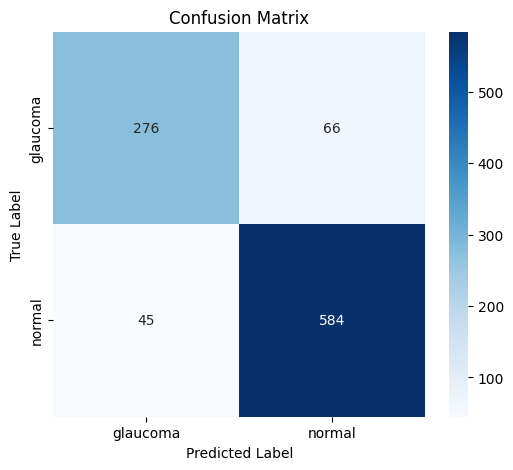


Overall Test Accuracy: 88.57%


In [7]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# We need to collect all predictions and true labels
all_preds = []
all_labels = []

# Set model to evaluation mode (very important!)
model.eval()

# No need to track gradients for evaluation
with torch.no_grad():
    for inputs, labels in tqdm(dataloaders['test'], desc="Testing"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Add this batch's predictions and labels to our master lists
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# --- 1. Print the Classification Report ---
# This gives us Accuracy, Precision, Recall, and F1-Score

# We need to map the labels (0, 1) to our class names
# class_names was defined in Day 1: ['glaucoma', 'normal']
print("\n--- Final Model Evaluation (Test Set) ---")
print(classification_report(all_labels, all_preds, target_names=class_names))


# --- 2. Print the Confusion Matrix ---
# This shows us *where* the model got confused
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Calculate and print overall test accuracy
test_accuracy = (cm[0, 0] + cm[1, 1]) / np.sum(cm)
print(f"\nOverall Test Accuracy: {test_accuracy*100:.2f}%")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 19.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 27.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 14.2 MB/s eta 0:00:00:00:0100:01
ERROR: pip's depe

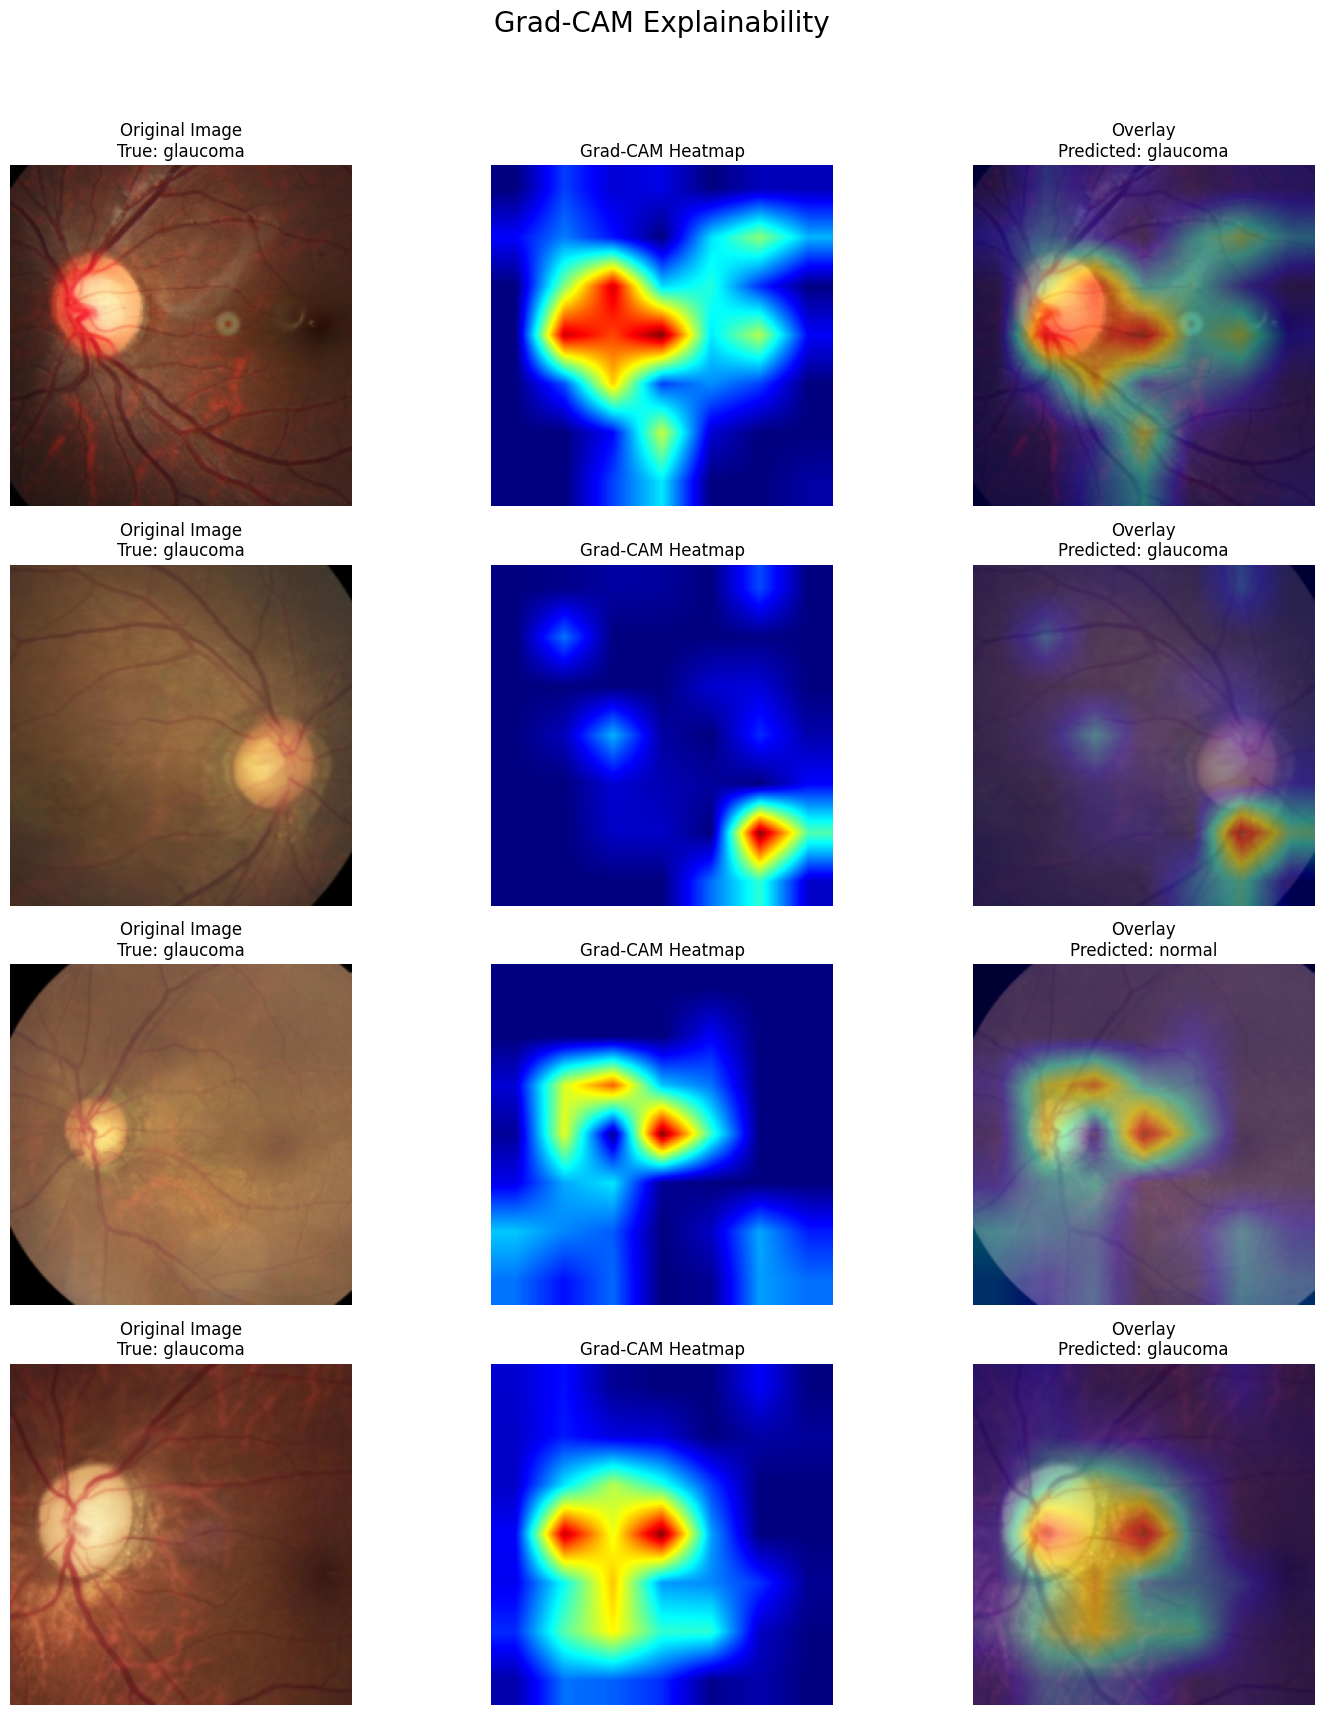

Grad-CAM visualization saved to grad_cam_examples.png


In [8]:
# Install captum for explainability, -q makes it "quiet"
!pip install captum -q

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch.nn.functional as F
from captum.attr import LayerGradCam
import cv2 # We'll use OpenCV to resize the heatmap

# --- 1. Helper Function to "Un-normalize" Images ---
# We need this to reverse our Day 1 transforms for plotting
_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

def unnormalize_image(tensor_img):
    """Reverses the normalization for plotting."""
    img = tensor_img.clone().to(device) # Don't modify original
    img = img * _std[:, None, None] + _mean[:, None, None]
    img = img.cpu().numpy()
    img = np.transpose(img, (1, 2, 0)) # C, H, W -> H, W, C
    img = np.clip(img, 0, 1)
    return img

# --- 2. Set up Grad-CAM ---
# We must be in eval mode
model.eval()
# We target the last convolutional block of MobileNetV2
target_layer = model.features[-1]
lgc = LayerGradCam(model, target_layer)

# --- 3. Get a few images from the test set ---
print("Generating Grad-CAM visualizations for a few test images...")
try:
    # Get one batch of test images and labels
    inputs, labels = next(iter(dataloaders['test']))
    inputs = inputs.to(device)
    labels = labels.to(device)
except Exception as e:
    print(f"Error getting test images: {e}")
    print("Make sure 'dataloaders['test']' is defined.")
    raise e

# --- 4. Generate and Plot Visualizations ---
num_images_to_show = 4
fig, axs = plt.subplots(num_images_to_show, 3, figsize=(15, 18))
fig.suptitle("Grad-CAM Explainability", fontsize=20)

for i in range(num_images_to_show):
    # Get image, label, and prediction
    input_img_tensor = inputs[i].unsqueeze(0) # (1, 3, 224, 224)
    original_img = unnormalize_image(inputs[i]) # (224, 224, 3) for plotting
    
    true_label_idx = labels[i].item()
    true_label_name = class_names[true_label_idx]

    output = model(input_img_tensor)
    pred_prob = F.softmax(output, dim=1)
    pred_label_idx = torch.argmax(pred_prob).item()
    pred_label_name = class_names[pred_label_idx]
    
    # Generate Grad-CAM attribution
    # We create the heatmap based on the model's *predicted* class
    attribution = lgc.attribute(input_img_tensor, target=pred_label_idx)
    
    # --- Process heatmap for plotting ---
    heatmap = attribution.squeeze().cpu().detach().numpy()
    heatmap = np.maximum(heatmap, 0) # Use only positive contributions
    heatmap = heatmap - np.min(heatmap)
    heatmap = heatmap / (np.max(heatmap) + 1e-10) # Normalize to 0-1
    
    # Resize heatmap to match the original image size
    heatmap = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
    heatmap = np.uint8(255 * heatmap) # Convert to 0-255
    heatmap_jet = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap_jet = cv2.cvtColor(heatmap_jet, cv2.COLOR_BGR2RGB) # Convert BGR to RGB

    # Create the overlay
    overlay = np.uint8(original_img * 255)
    overlay = cv2.addWeighted(overlay, 0.6, heatmap_jet, 0.4, 0)

    # --- Plotting ---
    # Plot 1: Original Image
    axs[i, 0].imshow(original_img)
    axs[i, 0].set_title(f"Original Image\nTrue: {true_label_name}")
    axs[i, 0].axis('off')

    # Plot 2: Heatmap Only
    axs[i, 1].imshow(heatmap_jet)
    axs[i, 1].set_title("Grad-CAM Heatmap")
    axs[i, 1].axis('off')

    # Plot 3: Overlay
    axs[i, 2].imshow(overlay)
    axs[i, 2].set_title(f"Overlay\nPredicted: {pred_label_name}")
    axs[i, 2].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout for title
plt.show()

# Save the plot as a file for your report
output_filename = "grad_cam_examples.png"
fig.savefig(output_filename)
print(f"Grad-CAM visualization saved to {output_filename}")